# Evaluation for Civirank
This is the notebook accompanying the Evaluation section of "TODO input title" where the ranker CiviRank is evaluated based on the Comment Data from the "DerStandard" comment sections from May 2019, kindly provided by Emma Fraxanet, see [here](https://academic.oup.com/pnasnexus/article/3/12/pgae276/7713083?login=false).

In [3]:
%load_ext autoreload
%autoreload 2
%pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix
from evaluation import EvaluationDataGenerator, EvaluationCollector
import pandas as pd
from civirank import CiviRank
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates
import os
from dotenv import load_dotenv
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel 

## Set Constants for Evaluation

In this section, we define the constants that determine the number of items to be evaluated in the analysis. This helps in maintaining consistency and reproducibility in our experiments.

- `ARTICLES_TO_EVALUATE`: The number of articles to be sampled and evaluated. Currently set to 10.
- `ARTICLES_TO_OVERVIEW`: The number of articles considered in overview diagrams.
- `AVERAGE_COMMENTS_VIEWED_ESTIMATE`: The number of comments we estimate one user to view on average, where we analyze toxicity and civility in detail.
- `CIVIRANK_SCROLL_WARNING_LIMIT`: = 0.` The threshold below wich CiviRank puts a scroll warning.

In [4]:
ARTICLES_TO_EVALUATE = 5
ARTICLES_TO_OVERVIEW = 5
AVERAGE_COMMENTS_VIEWED_ESTIMATE = 3
CIVIRANK_SCROLL_WARNING_LIMIT = -0.16 #similar to default setting
EXTERNAL_EVAL = True
EVAL_BIN_SIZE = 10
PRINT_PLOTS = True
FIGURE_PATH = "figures/"
TEMP_PATH = "temp/"
utils.FIGURE_PATH = FIGURE_PATH
rc = {
  "scatter.edgecolors": "none",
    # "font.size": 16,
    # "axes.titlesize": 18,
    # "axes.labelsize": 16,
    # "xtick.labelsize": 14,
    # "ytick.labelsize": 14,
    # "legend.fontsize": 14,
    }
#sns.set_context('paper', rc=rc) if PRINT_PLOTS else sns.set_context('notebook', rc=rc)
sns.set_theme('paper' if PRINT_PLOTS else 'notebook', 'white', rc=rc)
custom_palette = sns.color_palette("Set2", 8)
sns.set_palette(custom_palette)

## Data Import and Ranker Init
Here the Helper Class for Generating Data is initialized, it reads the data from the raw files and later provides util functions. Additionally the CiviRank ranker object is started.

In [5]:
load_dotenv()

path_to_data = "data/may_2019"
eval_gen = EvaluationDataGenerator(path_to_data)
ranker = CiviRank(language="ger", scroll_warning_limit=CIVIRANK_SCROLL_WARNING_LIMIT)

Language set to ger
ToxicityAnalyzer set to celadon


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Prosociality and Polarization Analyzers initialized
Civirank initialized!


### Comment Metadata
This imports the metadata for all comments on all articles in the Dataset, which includes all of May 2019.

In [6]:
metadata = eval_gen.get_comments_metadata()
print(f"Total amount of comments in Dataset: {len(metadata)}")

Total amount of comments in Dataset: 737903


## General Overview
First, the summed comments are analyzed in the context of the articles.
Most importantly, the median of comments on a article is calculated, as these are used in the thesis as examplary for "standard" cases of comment sections.
Other than that, the relation between total comments, total votes, up- and downvotes is explored and visualized

In [7]:
# Aggregate the sum of Votes_Pos and Votes_Neg for each Article_Id
aggregated = metadata.groupby('Article_Id').agg(
    counts=('Article_Id', 'size'),
    Votes_Pos_Sum=('Votes_Pos', 'sum'),
    Votes_Neg_Sum=('Votes_Neg', 'sum')
).reset_index()
print(f"Total amount of articles in Dataset: {len(aggregated)}")
aggregated["Votes_Total"] = aggregated["Votes_Neg_Sum"] + aggregated["Votes_Pos_Sum"]
aggregated["VotesToComments"] = aggregated["Votes_Total"] / aggregated["counts"]
aggregated["NegVotesToComments"] = aggregated["Votes_Neg_Sum"] / aggregated["counts"]
aggregated["PosffVotesToComments"] = aggregated["Votes_Pos_Sum"] / aggregated["counts"]
aggregated["NegVotesPercentage"] = (aggregated["Votes_Neg_Sum"] / aggregated["Votes_Total"]) * 100
aggregated["PosVotesPercentage"] = (aggregated["Votes_Pos_Sum"] / aggregated["Votes_Total"]) * 100
#print median, average, qantiles and max of the comment counts
print("The median of the comment counts is: ", aggregated["counts"].median())
print("The average of the comment counts is: ", aggregated["counts"].mean())
print("The 25% quantile of the comment counts is: ", aggregated["counts"].quantile(0.25))
print("The 75% quantile of the comment counts is: ", aggregated["counts"].quantile(0.75))
print("The maximum of the comment counts is: ", aggregated["counts"].max())
# get 10 articles counts closest to the median
aggregated["diff"] = abs(aggregated['counts'] - aggregated['counts'].median())

Total amount of articles in Dataset: 4499
The median of the comment counts is:  37.0
The average of the comment counts is:  164.0148921982663
The 25% quantile of the comment counts is:  10.0
The 75% quantile of the comment counts is:  138.0
The maximum of the comment counts is:  19973


## Extract Data under consideration of the Data Distribution
As the distribution of the comments is somewhat lognormal, we partition the dataset into bins of 0-10, 10-100, 100-1000 comments to account for all types of comment sections


In [8]:
# Try to load the variable
try:
  complete = pd.read_pickle(TEMP_PATH + "complete.pkl")
  overview = pd.read_pickle(TEMP_PATH + "overview.pkl")

  scores_log_bin_0 = pd.read_pickle(TEMP_PATH + "scores_log_bin_0.pkl")
  scores_log_bin_1 = pd.read_pickle(TEMP_PATH + "scores_log_bin_1.pkl")
  scores_log_bin_2 = pd.read_pickle(TEMP_PATH + "scores_log_bin_2.pkl")
  scores_log_bins = [scores_log_bin_0, scores_log_bin_1, scores_log_bin_2]

  sample_log_bin_0 = pd.read_pickle(TEMP_PATH + "sample_log_bin_0.pkl")
  sample_log_bin_1 = pd.read_pickle(TEMP_PATH + "sample_log_bin_1.pkl")
  sample_log_bin_2 = pd.read_pickle(TEMP_PATH + "sample_log_bin_2.pkl")
  sample_log_bins = [sample_log_bin_0, sample_log_bin_1, sample_log_bin_2]

  overview_log_bin_0 = pd.read_pickle(TEMP_PATH + "overview_log_bin_0.pkl")
  overview_log_bin_1 = pd.read_pickle(TEMP_PATH + "overview_log_bin_1.pkl")
  overview_log_bin_2 = pd.read_pickle(TEMP_PATH + "overview_log_bin_2.pkl")
  overviews = [overview_log_bin_0, overview_log_bin_1, overview_log_bin_2]

except FileNotFoundError:

  # parttion into logarithmic bins
  log_bin_0 = aggregated[aggregated['counts'] < 10]
  log_bin_1 = aggregated[(aggregated['counts'] >= 10) & (aggregated['counts'] < 100)]
  log_bin_2 = aggregated[(aggregated['counts'] >= 100) & (aggregated['counts'] < 1000)]

  sample_log_bin_0 = log_bin_0.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bin_1 = log_bin_1.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bin_2 = log_bin_2.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bins = [sample_log_bin_0, sample_log_bin_1, sample_log_bin_2]
  scores_log_bin_0 = []
  scores_log_bin_1 = []
  scores_log_bin_2 = []
  scores_log_bins = [scores_log_bin_0, scores_log_bin_1, scores_log_bin_2]
  overviews = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

  for i, bin in enumerate(sample_log_bins):
      for _, sample in bin.iterrows():
        article_id = sample["Article_Id"]
        comments, comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(article_id)
        scores = eval_gen.calculate_all_scores(comments_matched_to_metadata, comments, ranker)
        scores_log_bins[i].append(scores)
        comments = len(comments_matched_to_metadata)
        warnings = scores["Warning"].eq("Warning").sum()
        average_civiscore = scores["CiviScore"].mean()
        average_civiscore_without_warnings = scores[scores["Warning"].ne("Warning")]["CiviScore"].mean()
        new_row = pd.DataFrame({
            "article_id": [article_id],
            "comments": [comments],
            "warnings": [warnings],
            "average_civiscore": [average_civiscore],
            "warning_proportion": [warnings / comments],
            "average_civiscore_without_warnings": [average_civiscore_without_warnings],
        })
        overviews[i] = pd.concat([overviews[i], new_row], ignore_index=True)
  complete = pd.DataFrame()
  overview = pd.DataFrame()
  for i, bin in enumerate(scores_log_bins):
    overview = pd.concat([overview, overviews[i]], ignore_index=True)
    for scores in bin:
      complete = pd.concat([complete, scores], ignore_index=True)
      
  complete.to_pickle(TEMP_PATH + "complete.pkl")
  overview.to_pickle(TEMP_PATH + "overview.pkl")

  pd.to_pickle(scores_log_bins[0], TEMP_PATH + "scores_log_bin_0.pkl")
  pd.to_pickle(scores_log_bins[1], TEMP_PATH + "scores_log_bin_1.pkl")
  pd.to_pickle(scores_log_bins[2], TEMP_PATH + "scores_log_bin_2.pkl")

  pd.to_pickle(sample_log_bins[0], TEMP_PATH + "sample_log_bin_0.pkl")
  pd.to_pickle(sample_log_bins[1], TEMP_PATH + "sample_log_bin_1.pkl")
  pd.to_pickle(sample_log_bins[2], TEMP_PATH + "sample_log_bin_2.pkl")

  pd.to_pickle(overviews[0], TEMP_PATH + "overview_log_bin_0.pkl")
  pd.to_pickle(overviews[1], TEMP_PATH + "overview_log_bin_1.pkl")
  pd.to_pickle(overviews[2], TEMP_PATH + "overview_log_bin_2.pkl")


## Visualizing typical cases
For visualizing typical cases we first examine a range of articles pseudorandomly sampled between the 40th and the 60th quantile of comment counts, to get an impression of the typical case.

In [9]:
#randomly sample ARTICLES_TO_OVERVIEW articles from the iqr
iqr = aggregated[(aggregated['counts'] >= aggregated['counts'].quantile(0.4)) & (aggregated['counts'] <= aggregated['counts'].quantile(0.6))]
articles_to_evaluate = iqr.sample(n=ARTICLES_TO_OVERVIEW, random_state=1)

nice seeds: 45 1
very nice: none
semi nice 52

In [10]:
results = []
overview_typical = pd.DataFrame()

for i, row in articles_to_evaluate.iterrows():
    article_id = row["Article_Id"]
    comments, comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(article_id)
    scores = eval_gen.calculate_all_scores(comments_matched_to_metadata, comments, ranker)
    results.append(scores)
    new_row = pd.DataFrame({
        "article_id": [article_id],
        "comments": [len(comments_matched_to_metadata)],
        "warning": [scores["Warning"].eq("Warning").sum()],
        "average_civiscore": [scores["CiviScore"].mean()],
    })
    overview_typical = pd.concat([overview_typical, new_row], ignore_index=True)
overview_typical["warning_proportion"] = (overview_typical["warning"] / overview_typical["comments"])

KeyboardInterrupt: 

### Plot distribution of Civiscores

Median in CiviScores:  0.26678326802375996
Mean in CiviScores:  0.24159373170088164


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


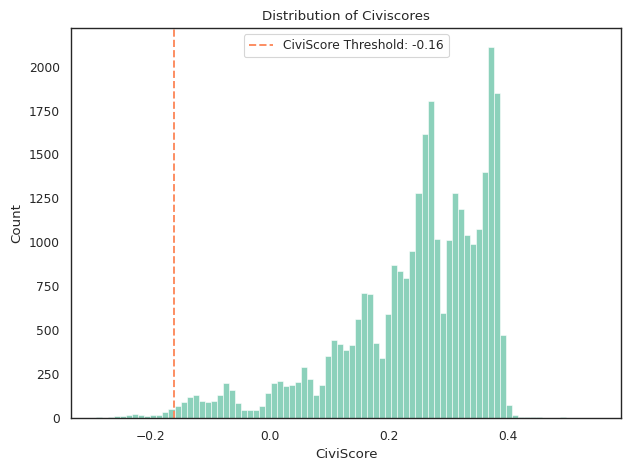

Comments ranked:  31276


In [11]:
g = sns.histplot(data=complete['CiviScore'])
plt.axvline(-0.16, color=custom_palette[1], linestyle='--', label=f'CiviScore Threshold: -0.16', linewidth=1.4)
print("Median in CiviScores: ", complete['CiviScore'].median())
print("Mean in CiviScores: ", complete['CiviScore'].mean())

plt.legend()
plt.title("Distribution of Civiscores")
utils.plot(PRINT_PLOTS, "civiscores_distribution", plt)
print("Comments ranked: ", len(complete))


The average MTLD is:  34.850016218949655
The median MTLD is:  32.256
The 25% quantile of the MTLD is:  15.375
The 75% quantile of the MTLD is:  48.583907119237104
The maximum of the MTLD is:  342.9999999999999


<Axes: xlabel='text', ylabel='Count'>

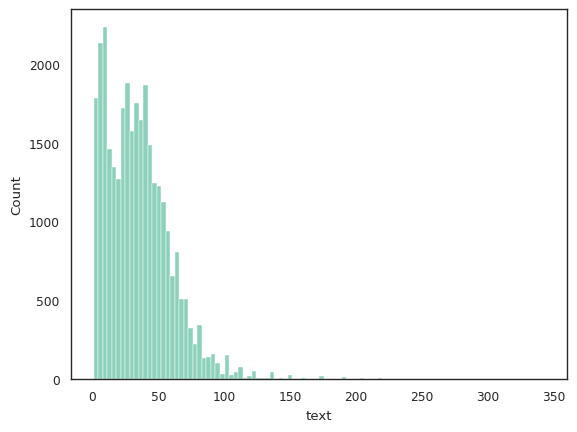

In [41]:
import spacy
from lexicalrichness import LexicalRichness
nlp = spacy.load("de_core_news_md")
    
def preprocess(text_series, nlp):
    text_series.copy()
    cleaned_text = text_series.replace(
        to_replace=[r"(?:https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,})"],
        value=[""],
        regex=True,
    )
    cleaned_text = cleaned_text.replace(to_replace=r"&.*;", value="", regex=True)
    cleaned_text = cleaned_text.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True)
    cleaned_text = cleaned_text.replace(to_replace=r"\s+", value=" ", regex=True)
    cleaned_text = cleaned_text.replace(to_replace=r"\@\w+", value="@user", regex=True)
    cleaned_text = cleaned_text.apply(lambda x: [token.lemma_ for token in nlp(x)])
    return cleaned_text

def calculate_mtld(text_series):
    lexical_richness = LexicalRichness(text_series, preprocessor=None, tokenizer=None)
    
    try:
        mtld_value = lexical_richness.mtld()
    except ZeroDivisionError:
        mtld_value = None

    return mtld_value

try:
    mtld_complete = pd.read_pickle(TEMP_PATH + "mtld_complete.pkl")
except FileNotFoundError:
    text_to_mtld = preprocess(complete["text"], nlp)
    mtld_complete = text_to_mtld.apply(lambda x: calculate_mtld(x))
    pd.to_pickle(mtld_complete, TEMP_PATH + "mtld_complete.pkl")
    
print("The average MTLD is: ", mtld_complete.mean())
print("The median MTLD is: ", mtld_complete.median())
print("The 25% quantile of the MTLD is: ", mtld_complete.quantile(0.25))
print("The 75% quantile of the MTLD is: ", mtld_complete.quantile(0.75))
print("The maximum of the MTLD is: ", mtld_complete.max())
sns.histplot(data=mtld_complete, bins =100)



The average MTLD is:  34.850016218949655
The median MTLD is:  32.256
The 25% quantile of the MTLD is:  15.375
The 75% quantile of the MTLD is:  48.583907119237104
The 90% quantile of the MTLD is:  64.76949713941583
The maximum of the MTLD is:  342.9999999999999
Normlaizedmtld max:  1.0


<Axes: xlabel='text', ylabel='Count'>

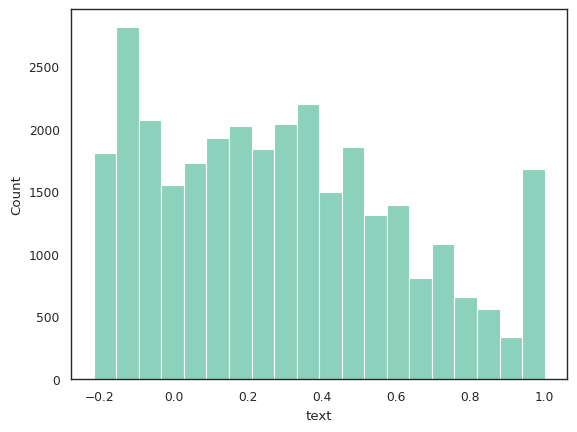

In [69]:
def min_max(x, min, max, bottom_aim, top_aim):
  return ((x - min) * (top_aim - bottom_aim)) / (max - min)
print("The average MTLD is: ", mtld_complete.mean())
print("The median MTLD is: ", mtld_complete.median())
print("The 25% quantile of the MTLD is: ", mtld_complete.quantile(0.25))
print("The 75% quantile of the MTLD is: ", mtld_complete.quantile(0.75))
print("The 90% quantile of the MTLD is: ", mtld_complete.quantile(0.9))

print("The maximum of the MTLD is: ", mtld_complete.max())

normalized_mtld = mtld_complete.apply(lambda x: min(x, 1)) # 50 (75 percent quantile of our datas mtld) as 1, 0 as -0.15

normalized_mtld = mtld_complete.apply(lambda x: min(x, 80)) # 50 (75 percent quantile of our datas mtld) as 1, 0 as -0.15
normalized_mtld = normalized_mtld.apply(lambda x: x/65 - 15/65)
normalized_mtld = normalized_mtld.apply(lambda x: min(x, 1))
print("Normlaizedmtld max: ", normalized_mtld.max())
sns.histplot(data=normalized_mtld, bins =20)


The average prosociality is:  0.029249600676383977
The median prosociality is:  0.0005890130996704102
The 25% quantile of the prosociality is:  -0.026941895484924316
The 75% quantile of the prosociality is:  0.033880919218063354
The maximum of the prosociality is:  0.8883622884750366
The minimum of the prosociality is:  -0.16628336906433105
Post_Id              933
CiviRank             933
CiviScore            933
Warning              933
Reddit_Score         933
Reddit_Score_Rank    933
text                 933
Score                933
Score_Rank           933
Timestamp            933
Parent_Id            933
Votes_Neg            933
Votes_Pos            933
id                   933
trustworthiness        0
no_toxicity          933
no_polarization      933
prosociality         933
mtld                 933
compound_score       933
dtype: int64


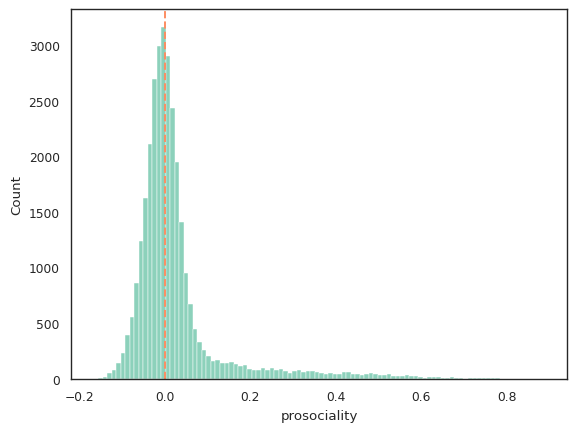



The average polarization is:  -0.06053322374111765
The median polarization is:  -0.04002636671066284
The 25% quantile of the polarization is:  -0.08656191825866699
The 75% quantile of the polarization is:  -0.004481106996536255
The maximum of the polarization is:  0.14323186874389648
The minimum of the polarization is:  -0.8452422618865967


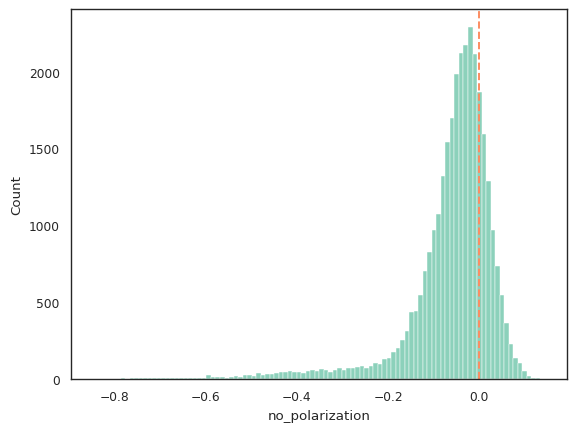

Post_Id              31276
CiviRank             31276
CiviScore            31276
Warning              31276
Reddit_Score         31276
Reddit_Score_Rank    31276
text                 31276
Score                31276
Score_Rank           31276
Timestamp            31276
Parent_Id            31276
Votes_Neg            31276
Votes_Pos            31276
id                   31276
trustworthiness        297
no_toxicity          31276
no_polarization      31276
prosociality         31276
mtld                 31276
compound_score       31276
dtype: int64


In [46]:
print("The average prosociality is: ", complete['prosociality'].mean())
print("The median prosociality is: ", complete['prosociality'].median())
print("The 25% quantile of the prosociality is: ", complete['prosociality'].quantile(0.25))
print("The 75% quantile of the prosociality is: ", complete['prosociality'].quantile(0.75))
print("The maximum of the prosociality is: ", complete['prosociality'].max())
print("The minimum of the prosociality is: ", complete['prosociality'].min())
print(complete[complete['prosociality'] > 0.4].count())

sns.histplot(complete['prosociality'], bins=100)
plt.axvline(0.0, color=custom_palette[1], linestyle='--', label=f'Prosociality Threshold: 0.4', linewidth=1.4)
plt.show()
print('\n')
print("The average polarization is: ", complete['no_polarization'].mean())
print("The median polarization is: ", complete['no_polarization'].median())
print("The 25% quantile of the polarization is: ", complete['no_polarization'].quantile(0.25))
print("The 75% quantile of the polarization is: ", complete['no_polarization'].quantile(0.75))
print("The maximum of the polarization is: ", complete['no_polarization'].max())
print("The minimum of the polarization is: ", complete['no_polarization'].min())
sns.histplot(complete['no_polarization'], bins=100)
plt.axvline(0.0, color=custom_palette[1], linestyle='--', label=f'Prosociality Threshold: 0.4', linewidth=1.4)

plt.show()

print(complete[complete['no_polarization'] < 0.4].count())


The average prosociality is:  0.28434912148804475
The median prosociality is:  0.22129582881927493
The 25% quantile of the prosociality is:  0.16072782993316653
The 75% quantile of the prosociality is:  0.2945380222797394
The maximum of the prosociality is:  2.1743970346450805
The minimum of the prosociality is:  -0.1458234119415283


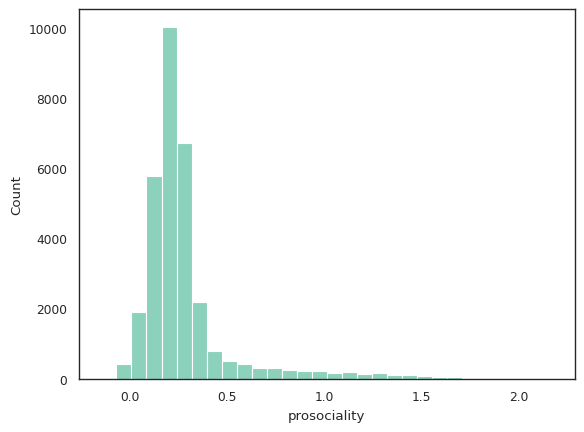



The average polarization is:  -0.35317309223045884
The median polarization is:  -0.3080580067634583
The 25% quantile of the polarization is:  -0.41043622016906744
The 75% quantile of the polarization is:  -0.2298584353923798
The maximum of the polarization is:  0.09511011123657226
The minimum of the polarization is:  -2.079532976150513


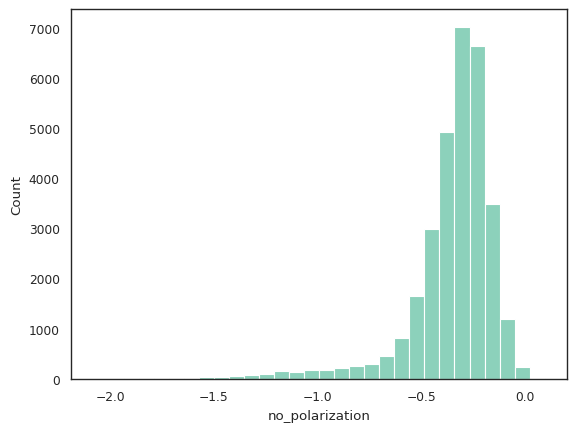

In [ ]:
def min_max(x, min, max, bottom_aim, top_aim):
  return ((x - min) * (top_aim - bottom_aim)) / (max - min)

scaled_pol = complete['no_polarization'].apply(lambda x: min_max(x, 0.1, -0.4, 0.1, -1))
scaled_prosoc = complete['prosociality'].apply(lambda x: min_max(x, -0.1, 0.4, -0.1, 1))

print("The average prosociality is: ", scaled_prosoc.mean())
print("The median prosociality is: ", scaled_prosoc.median())
print("The 25% quantile of the prosociality is: ", scaled_prosoc.quantile(0.25))
print("The 75% quantile of the prosociality is: ", scaled_prosoc.quantile(0.75))
print("The maximum of the prosociality is: ", scaled_prosoc.max())
print("The minimum of the prosociality is: ", scaled_prosoc.min())

sns.histplot(scaled_prosoc, bins=30)
plt.show()
print('\n')
print("The average polarization is: ", scaled_pol.mean())
print("The median polarization is: ", scaled_pol.median())
print("The 25% quantile of the polarization is: ", scaled_pol.quantile(0.25))
print("The 75% quantile of the polarization is: ", scaled_pol.quantile(0.75))
print("The maximum of the polarization is: ", scaled_pol.max())
print("The minimum of the polarization is: ", scaled_pol.min())
sns.histplot(scaled_pol, bins=30)
plt.show()



The average prosociality is:  0.0722832553155049
The median prosociality is:  0.001963376998901367
The 25% quantile of the prosociality is:  -0.08980631828308105
The 75% quantile of the prosociality is:  0.11293639739354452
The maximum of the prosociality is:  1.0
The minimum of the prosociality is:  -0.5542778968811035


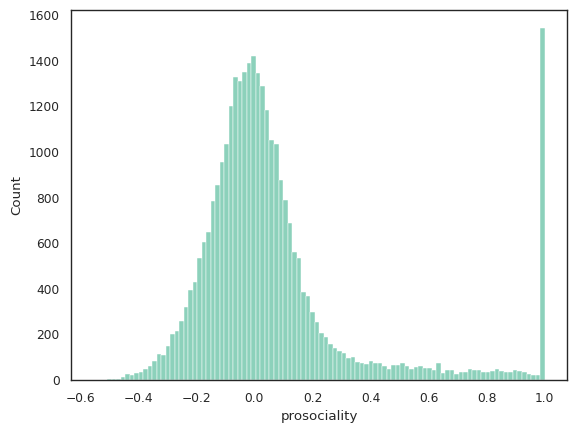



The average polarization is:  -0.18541886661446766
The median polarization is:  -0.13342122236887616
The 25% quantile of the polarization is:  -0.28853972752889
The 75% quantile of the polarization is:  -0.014937023321787517
The maximum of the polarization is:  0.47743956247965497
The minimum of the polarization is:  -1.0


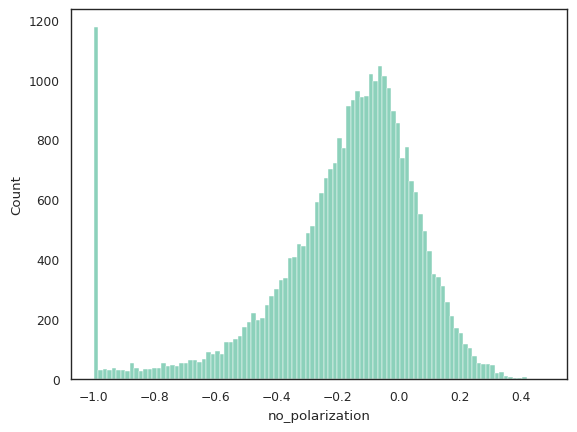

In [47]:
def min_max(x, min, max, bottom_aim, top_aim):
  return ((x - min) * (top_aim - bottom_aim)) / (max - min)

scaled_pol = complete['no_polarization'].apply(lambda x: min_max(x, 0, -0.3, 0, -1))
scaled_prosoc = complete['prosociality'].apply(lambda x: min_max(x, 0, 0.3, 0, 1))
scaled_pol = scaled_pol.apply(lambda x: 1 if x > 1 else x)
scaled_pol = scaled_pol.apply(lambda x: -1 if x < -1 else x)
scaled_prosoc = scaled_prosoc.apply(lambda x: 1 if x > 1 else x)
scaled_prosoc= scaled_prosoc.apply(lambda x: -1 if x < -1 else x)
print("The average prosociality is: ", scaled_prosoc.mean())
print("The median prosociality is: ", scaled_prosoc.median())
print("The 25% quantile of the prosociality is: ", scaled_prosoc.quantile(0.25))
print("The 75% quantile of the prosociality is: ", scaled_prosoc.quantile(0.75))
print("The maximum of the prosociality is: ", scaled_prosoc.max())
print("The minimum of the prosociality is: ", scaled_prosoc.min())

sns.histplot(scaled_prosoc, bins=100)
plt.show()
print('\n')
print("The average polarization is: ", scaled_pol.mean())
print("The median polarization is: ", scaled_pol.median())
print("The 25% quantile of the polarization is: ", scaled_pol.quantile(0.25))
print("The 75% quantile of the polarization is: ", scaled_pol.quantile(0.75))
print("The maximum of the polarization is: ", scaled_pol.max())
print("The minimum of the polarization is: ", scaled_pol.min())
sns.histplot(scaled_pol, bins=100)
plt.show()


In [89]:
weights = {
    "no_toxicity": 1,
    "no_polarization": 2,
    "mtld": 0.5,
    "trustworthiness": 2,
    "prosociality": 2
}

def calculate_compound_score(row, weights, debug=False):
    norm = 0
    compound_score = 0
    for score in weights.keys():
        if row[score] == row[score]: # nan-check
            compound_score += row[score] * weights[score]
            norm += weights[score]
    if norm != 0:
        return compound_score / norm
    else:
        return np.nan


scaled_df = pd.DataFrame({
    "trustworthiness": complete["trustworthiness"],
    "no_toxicity": complete["no_toxicity"],
    "no_polarization": scaled_pol,
    "prosociality": scaled_prosoc,
    "mtld": normalized_mtld,
})

# Calculate compound_score for each row in scaled_df
scaled_df["compound_score"] = scaled_df.apply(calculate_compound_score, args=(weights, False), axis=1)

In [90]:
print(scaled_df["compound_score"].quantile(0.035))
print(len(scaled_df[scaled_df["compound_score"] < -0.1])/len(scaled_df))


-0.09933440568829853
0.034755083770303105


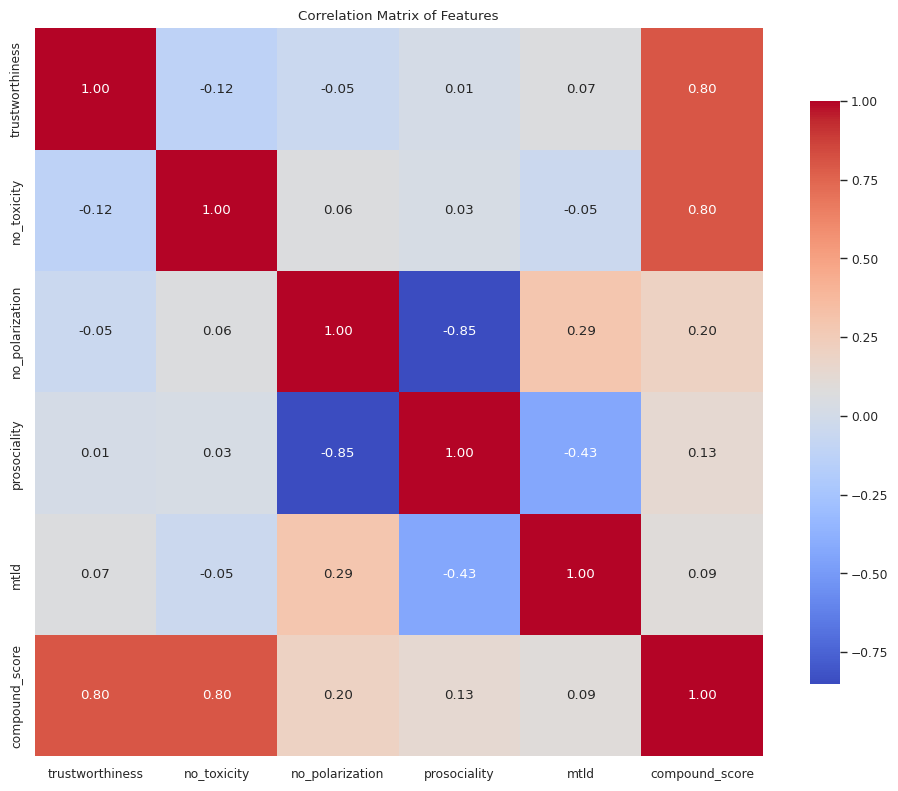

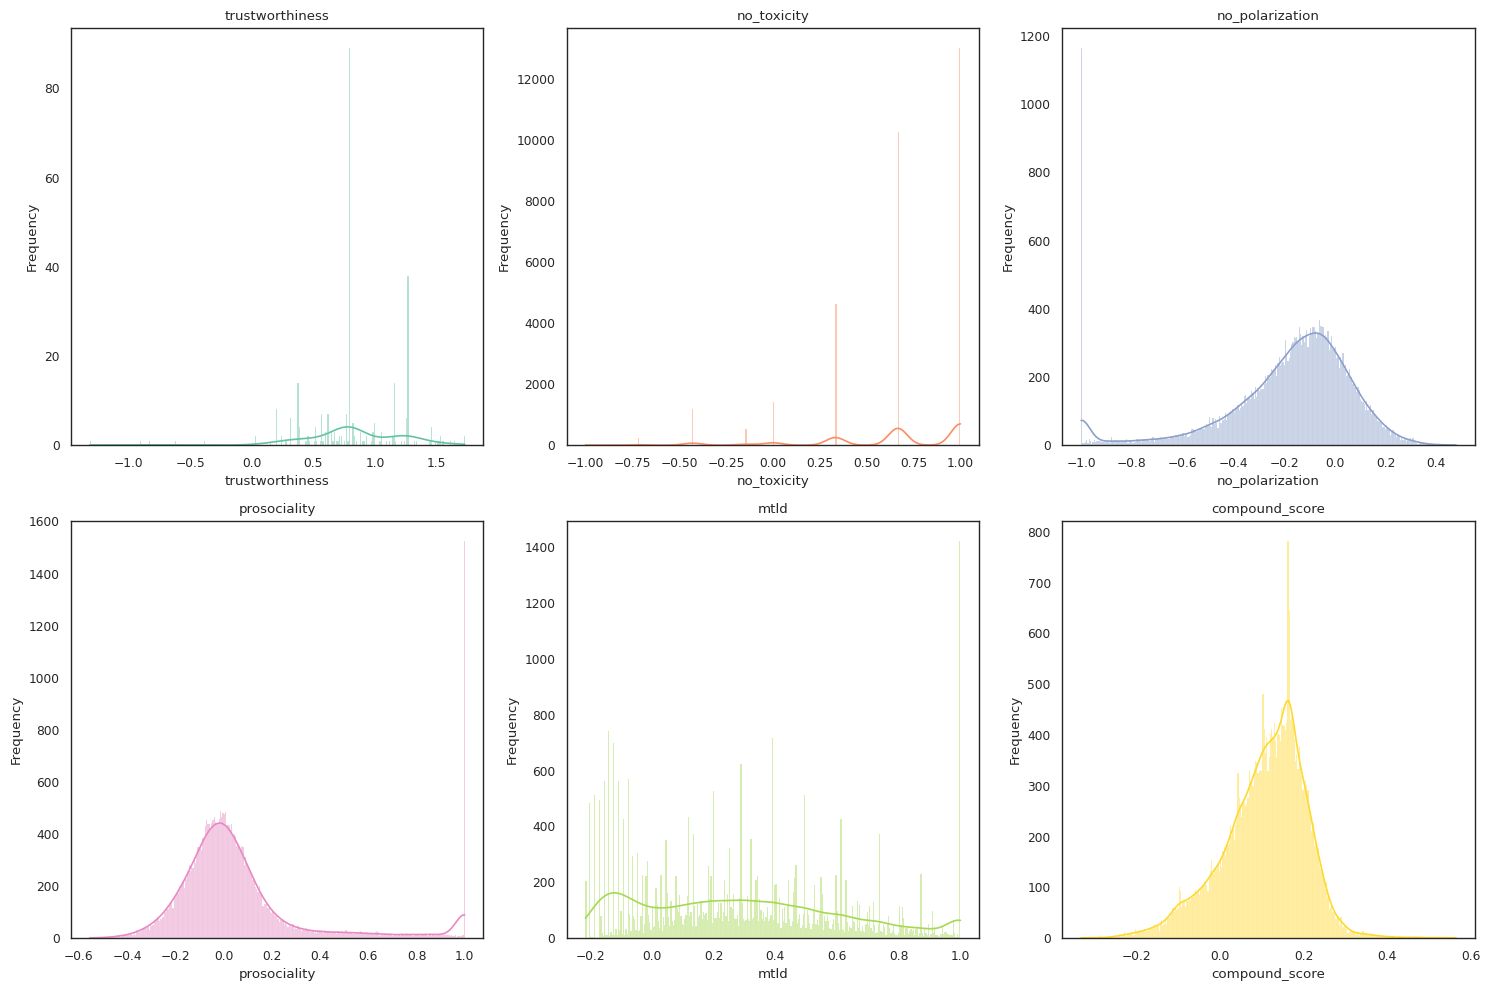

In [91]:
#for all rows in subser, show histogram and correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "correlation_matrix", plt)
# Plot the distribution of each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(scaled_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(scaled_df[column], bins=300, kde=True, color=custom_palette[i])
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "feature_distribution", plt)

In [18]:
subset = complete[["compound_score","trustworthiness", "no_toxicity", "no_polarization", "prosociality", "mtld"]].copy()
subset["mtld"] = subset["mtld"] *0.5

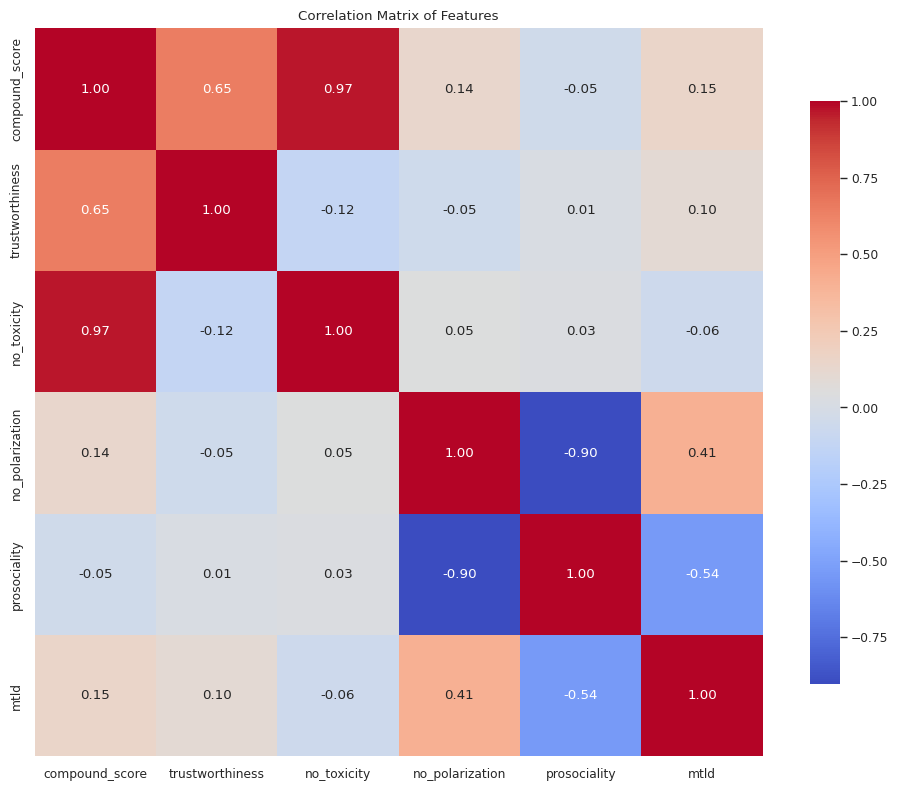

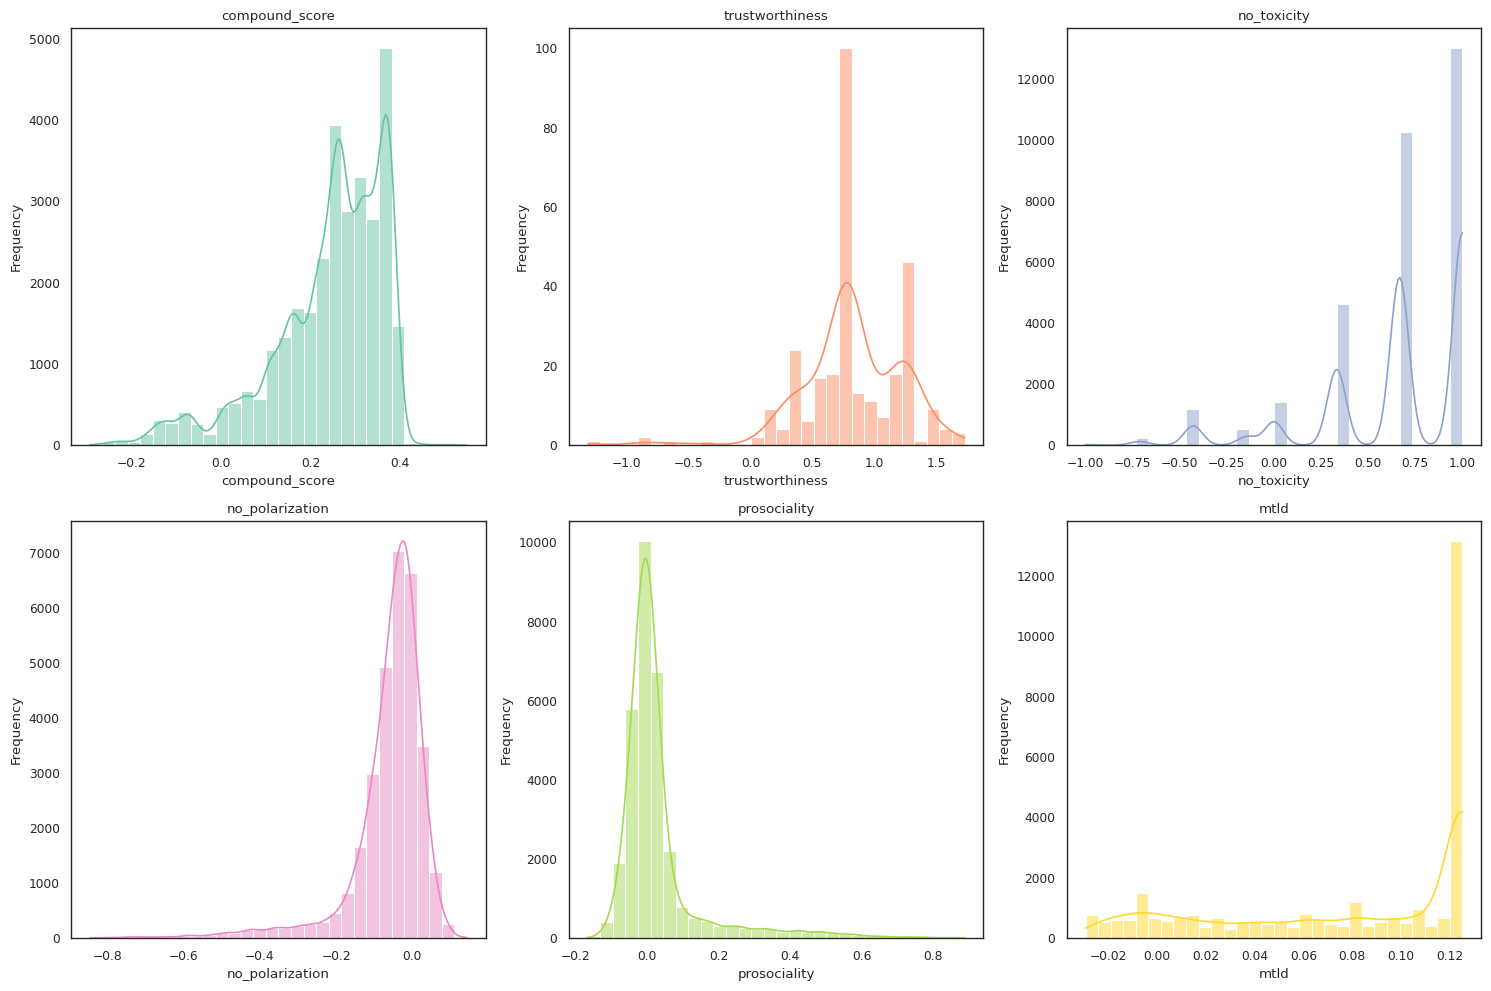

In [19]:
#for all rows in subser, show histogram and correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "correlation_matrix", plt)
# Plot the distribution of each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(subset.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(subset[column], bins=30, kde=True, color=custom_palette[i])
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "feature_distribution", plt)